Deflection at top (w(0)): -1.043320e-19 m
Slope at top (dw/dz(0)): 2.409752e-18 rad
Deflection at bottom (w(H_total)): 4.342698e-23 m
Slope at bottom (dw/dz(H_total)): 3.202016e-21 rad


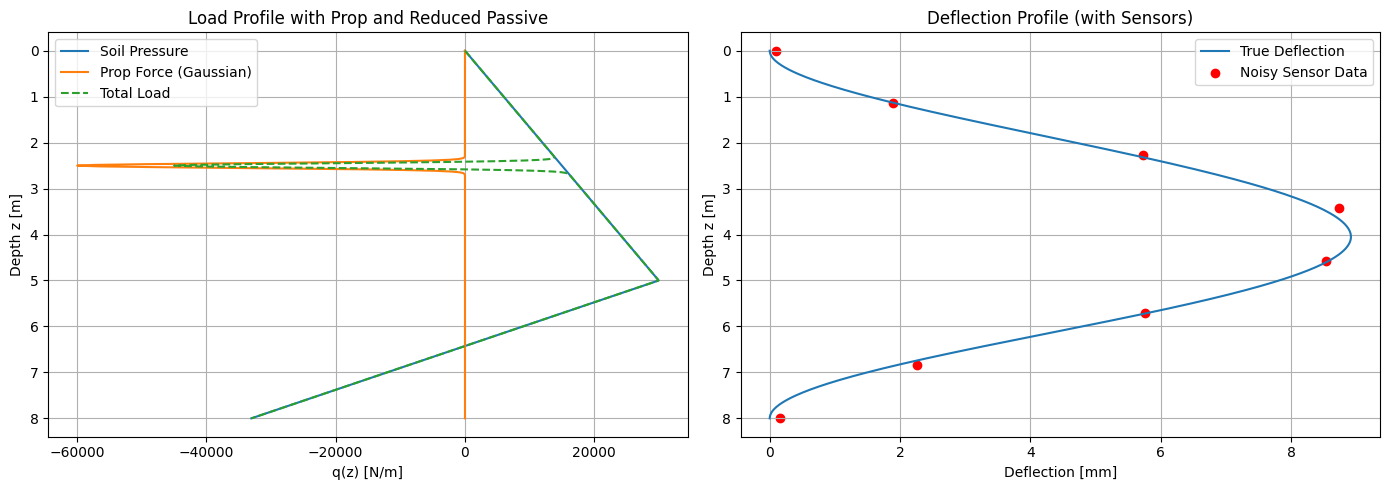

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import pandas as pd
import tensorflow as tf

# --- 1. Wall and Soil Parameters ---
H_exposed = 5.0
D_embed = 3.0
H_total = H_exposed + D_embed
L = H_total
EI = 20e6  # Nm²

gamma = 18.0 * 1e3  # N/m³
Ka = 0.333
Kp_mobilised = 1.5  # Reduced passive pressure coefficient
Kp = 3.0
z_prop = 2.5       # Depth of prop from top [m]
zR_prop = 60e3   # N (resisting direction, into wall)

# --- 2. Load Functions ---

# Active + Reduced Passive Pressure
def q_soil(z):
    return np.where(
        z <= H_exposed,
        Ka * gamma * z,
        Ka * gamma * z - Kp_mobilised * gamma * (z - H_exposed)
    )

# Gaussian approximation of point prop force (resisting)
def gaussian_prop(z, z_p, sigma=0.05):
     # scale height so area = total_force
    return  np.exp(-0.5 * ((z - z_p) / sigma) ** 2)


# Total load: Soil pressure - prop resistance
def q_total(z):
    return q_soil(z) - zR_prop * gaussian_prop(z, z_prop)

# --- 3. Solve Beam BVP ---

def beam_ode(z, y):
    return np.vstack([y[1], y[2], y[3], q_total(z) / EI])

def bc_bvp(ya, yb):
    return np.array([ya[0], ya[1], yb[0], yb[1]])

z_bvp_sol = np.linspace(0, H_total, 500)
y_init_bvp = np.zeros((4, z_bvp_sol.size))
sol = solve_bvp(beam_ode, bc_bvp, z_bvp_sol, y_init_bvp)

z_plot = np.linspace(0, H_total, 500)
w_true = sol.sol(z_plot)[0]   #solve BCs with dense sampled z

# --- 4. Sensor Data with Noise ---
num_sensors = 8
sensor_indices = np.linspace(0, len(z_plot) - 1, num_sensors, dtype=int)
z_sensors = z_plot[sensor_indices]
w_sensors = w_true[sensor_indices]
np.random.seed(42)
noise = np.random.normal(0, 0.0002, size=w_sensors.shape)
w_sensors_noisy = w_sensors + noise

# --- 5. Print Boundary Values ---
print(f"Deflection at top (w(0)): {sol.sol(0)[0]:.6e} m")
print(f"Slope at top (dw/dz(0)): {sol.sol(0)[1]:.6e} rad")
print(f"Deflection at bottom (w(H_total)): {sol.sol(H_total)[0]:.6e} m")
print(f"Slope at bottom (dw/dz(H_total)): {sol.sol(H_total)[1]:.6e} rad")

# --- 6. Plot ---
q_soil_vals = q_soil(z_plot)  # kN/m
q_prop_vals = -zR_prop * gaussian_prop(z_plot, z_prop)
q_total_vals = q_total(z_plot)
plt.figure(figsize=(14, 5))

# Load Profile
plt.subplot(1, 2, 1)
plt.plot(q_soil_vals, z_plot, label="Soil Pressure")
plt.plot(q_prop_vals, z_plot, label="Prop Force (Gaussian)")
plt.plot(q_total_vals, z_plot, label="Total Load", linestyle="--")
plt.gca().invert_yaxis()
plt.title("Load Profile with Prop and Reduced Passive")
plt.xlabel("q(z) [N/m]")
plt.ylabel("Depth z [m]")
plt.grid(True)
plt.legend()

# Deflection Profile
plt.subplot(1, 2, 2)
plt.plot(w_true * 1000, z_plot, label="True Deflection")
plt.scatter(w_sensors_noisy * 1000, z_sensors, color='red', label="Noisy Sensor Data")
plt.gca().invert_yaxis()
plt.title("Deflection Profile (with Sensors)")
plt.xlabel("Deflection [mm]")
plt.ylabel("Depth z [m]")
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()



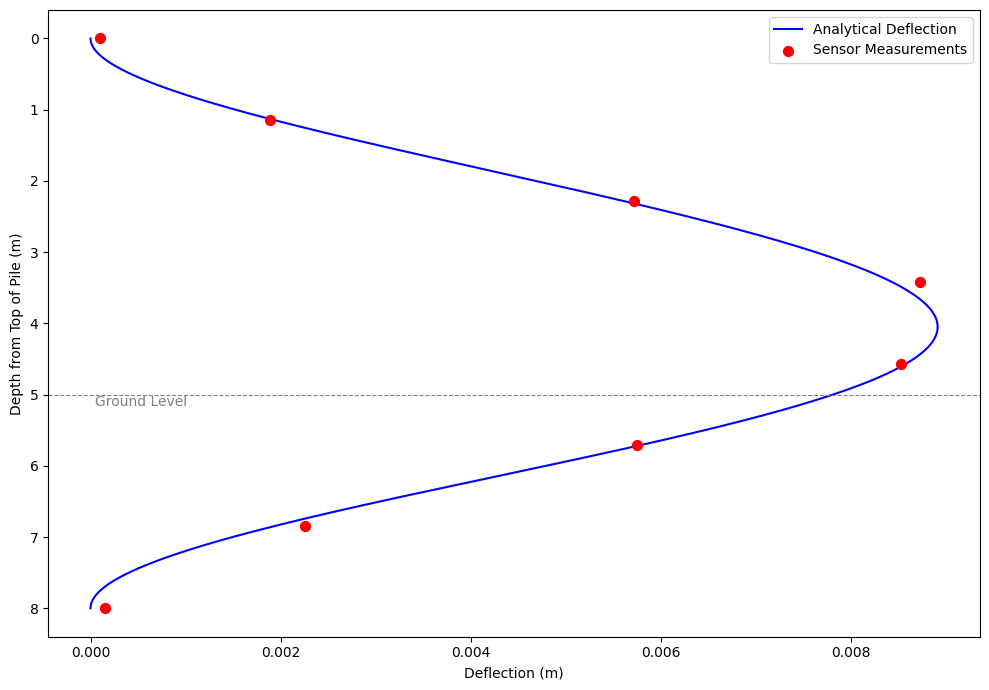

In [174]:
# --- 4. Plotting the Data ---
plt.figure(figsize=(10, 7))

# Plot analytical deflection as a line
plt.plot(w_true, z_plot, label='Analytical Deflection', color='blue', linestyle='-')

# Plot sensor measured deflection as points
plt.scatter(w_sensors_noisy, z_sensors, label='Sensor Measurements', color='red', marker='o', s=50, zorder=5) # zorder to ensure points are on top

#plt.title('Analytical Pile Deflection and noisy sensor Measurements')
plt.xlabel('Deflection (m)')
plt.ylabel('Depth from Top of Pile (m)')
plt.grid(False)
plt.legend()
plt.gca().invert_yaxis() # Invert y-axis to show depth increasing downwards
plt.axhline(H_exposed, color='gray', linestyle='--', linewidth=0.8, label='Ground Level') # Mark ground level
plt.text(plt.xlim()[0] + (plt.xlim()[1] - plt.xlim()[0]) * 0.05, H_exposed + 0.2, 'Ground Level', color='gray', va='bottom')

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [175]:
# --- 5. Normalization and Non-dimensionalization Setup ---
z_sensors_norm = z_sensors / L
z_plot_norm = z_plot / L

w_max = np.max(np.abs(w_true)) # Max true deflection for w normalization
# Calculate q_max for q normalization. Using max abs value of true q
q_max = np.max(np.abs(q_total(z_plot)))
q_norm = q_total(z_plot) / q_max

if q_max == 0: # Avoid division by zero if q_true is all zeros (unlikely here)
    q_max = 1.0
H_scale = q_max / 10.0
w_sensors_norm = w_sensors_noisy / w_max    #maybe normalize using max(w_noisy) ??

# ---- 6. Tensor conversion
z_sensors_tf = tf.convert_to_tensor(z_sensors_norm.reshape(-1, 1), dtype=tf.float32)
w_sensors_tf = tf.convert_to_tensor(w_sensors_norm.reshape(-1, 1), dtype=tf.float32)
z_uniform = np.linspace(0, 1, 180)
# 10 extra points concentrated around z = 0.3125 (±0.01)
z_cluster = np.linspace(0.3025, 0.3225, 20)   #known prop applied location
# Combine and sort
z_colloc = np.sort(np.concatenate([z_uniform, z_cluster])).reshape(-1, 1)
z_colloc_tf = tf.convert_to_tensor(z_colloc, dtype=tf.float32)


In [176]:
# --- 7. NN Model ---
def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),                #inputs single z
        tf.keras.layers.Dense(30, activation='swish'),
        tf.keras.layers.Dense(30, activation='swish'),
        tf.keras.layers.Dense(30, activation='swish'),
        #tf.keras.layers.Dense(30, activation='swish'),
        tf.keras.layers.Dense(1)                          #outputs single w
    ])

model = make_model()

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 30)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,951 (7.62 KB)

 Trainable params: 1,951 (7.62 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
# --- 8. Initialize b1, c1, b2, c2
m_a = tf.Variable(0.5, dtype=tf.float32)
m_p = tf.Variable(1, dtype=tf.float32)
m_prop = tf.Variable(1, dtype=tf.float32)


# --- 9. Learning Rate Scheduler ---
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, # Slightly lower initial LR
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [178]:
# --- 10. Derivative function ---
def compute_derivatives(z_input):   #normalized input gives normalized output
    with tf.GradientTape() as tape4:
        tape4.watch(z_input)
        with tf.GradientTape() as tape3:
            tape3.watch(z_input)
            with tf.GradientTape() as tape2:
                tape2.watch(z_input)
                with tf.GradientTape() as tape1:
                    tape1.watch(z_input)
                    w_norm = model(z_input) # This is w_normalized
                dw_norm = tape1.gradient(w_norm, z_input)
            d2w_norm = tape2.gradient(dw_norm, z_input)
        d3w_norm = tape3.gradient(d2w_norm, z_input)
    d4w_norm = tape4.gradient(d3w_norm, z_input)
    return w_norm, dw_norm, d2w_norm, d3w_norm, d4w_norm

#--- 11.  Piecewise q(z) - now outputs normalized q
def gaussian_prop_tf(z, z_p, sigma=0.005):
    return tf.exp(-0.5 * tf.square((z - z_p) / sigma))

def piecewise_q_normalized(z_phys):  #input unnormalized locations
    q_prop =  (zR_prop) * gaussian_prop_tf(z_phys, z_prop) #q_prop doesnt affect embedded part?
    q_total = tf.where(z_phys <= H_exposed, (m_a * gamma * Ka * z_phys - q_prop), (m_a * gamma * Ka * z_phys - m_p*gamma*Kp*(z_phys-H_exposed)))
    return q_total / q_max           #normalized using max true load


In [179]:
def trapz_tf(y, x): #non-uniform sampling
    area = 0
    for i in range(1, y.shape[0]):
      area += (x[i] - x[i - 1]) * (y[i] + y[i - 1]) / 2
    return area

In [180]:
# --- Curriculum Training Epoch Definitions ---
N_DATA_ONLY_EPOCHS = 10000  # Phase 1: Data only
N_BC_EPOCHS = 20000  # Phase 2: Introduce boundary conditions
N_PHYSICS_EPOCHS = 30000    # Phase 3: Introduce physics equation

@tf.function
def train_step(epoch_val):
    with tf.GradientTape(persistent=True) as tape:

        # ---Physics Loss
        z_phys_colloc = z_colloc_tf * L
        w_norm, dw_norm, _, d3w_norm, d4w_norm = compute_derivatives(z_colloc_tf) #w_norm : current deflection prediction
        q_hat_norm = piecewise_q_normalized(z_phys_colloc)            #q_hat_norm : current loading params
        physics_residual = d4w_norm * (EI * w_max / (L**4 * q_max)) - q_hat_norm

        q_phys = (q_hat_norm) * q_max
        Vw = (EI * w_max / (L**3)) * d3w_norm         # signs here?? positive is into soil. at exposed region support should be against of soil pressure?
        H_tot = trapz_tf(q_phys, z_phys_colloc)                      # N
        r_H   = (Vw[0] - Vw[-1]) + H_tot
        eqH_loss = tf.squeeze(tf.square(r_H / H_scale) / 10.0, -1)

        physics_loss = tf.reduce_mean(tf.square(physics_residual)) + eqH_loss

        # ---Data loss
        w_pred, _, _, _, _ = compute_derivatives(z_sensors_tf)  #couldve use the model directly?
        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

        bc_disp = tf.reduce_mean(tf.square([w_norm[0], w_norm[-1]]))
        bc_deriv = tf.reduce_mean(tf.square([dw_norm[0], dw_norm[-1]]))
        bc_loss  = bc_disp + bc_deriv
        # --- Curriculum Logic ---
        if epoch_val < N_DATA_ONLY_EPOCHS:
            # Phase 1: Mostly data, light physics
            w_data, w_phys, w_bc = 1.0, 0.1, 0.0
        elif epoch_val < N_BC_EPOCHS:
            # Phase 2: Physics dominant, little data
            w_data, w_phys, w_bc = 0.2, 1.0, 0.0
        else:
            # Phase 3: All terms used, 20000 epochs
            w_data, w_phys, w_bc = 0.2, 1.0, 0.5

        total_loss = (
            w_data * data_loss +
            w_phys * physics_loss +
            w_bc * bc_loss
        )

    variables = model.trainable_variables + [m_a, m_p]
    grads = tape.gradient(total_loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    del tape
    return total_loss, data_loss, physics_loss, eqH_loss, bc_loss, w_data, w_phys, w_bc

In [ ]:
history = {k: [] for k in ["loss", "data", "phys", "bc", 'eql_contribution']}
TOTAL_EPOCHS = 40000
history_params = {"m_a": [], "m_p": []}

for epoch in range(TOTAL_EPOCHS):
    loss, data_l, phys_l, eqh_l, bc_l, w_data, w_phys, w_bc = train_step(tf.cast(epoch, dtype = tf.float32))

    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history["eql_contribution"].append(float(eqh_l.numpy() / phys_l.numpy()))
    history_params["m_a"].append(m_a.numpy())
    history_params["m_p"].append(m_p.numpy())
    #history_params["m_prop"].append(m_prop.numpy())

    if epoch % 1000 == 0 or epoch in [N_PHYSICS_EPOCHS - 1, N_PHYSICS_EPOCHS,
                                      N_BC_EPOCHS - 1, N_BC_EPOCHS,
                                      TOTAL_EPOCHS - 1]:
        print(f"Epoch {epoch:5d} | Total: {loss.numpy().item():.4e} | Data: {data_l.numpy().item():.4e} | Phys: {phys_l.numpy().item():.4e} |Equilibrium: {eqh_l.numpy().item():.4e} | BC: {bc_l.numpy().item():.4e}")
        print(f"       Weights: W_Data={w_data:.1f}, W_Phys={w_phys:.1f}, W_BC={w_bc:.1f}")




Epoch     0 | Total: 1.1270e+01 | Data: 3.6669e-01 | Phys: 1.0903e+02 |Equilibrium: 1.0802e+02 | BC: 1.4862e-03
       Weights: W_Data=1.0, W_Phys=0.1, W_BC=0.0
Epoch  1000 | Total: 7.7736e-02 | Data: 1.7227e-02 | Phys: 6.0509e-01 |Equilibrium: 9.2967e-04 | BC: 2.1972e+01
       Weights: W_Data=1.0, W_Phys=0.1, W_BC=0.0
Epoch  2000 | Total: 6.6764e-02 | Data: 1.4892e-02 | Phys: 5.1872e-01 |Equilibrium: 4.9846e-04 | BC: 1.8986e+01
       Weights: W_Data=1.0, W_Phys=0.1, W_BC=0.0
Epoch  3000 | Total: 6.2641e-03 | Data: 2.1394e-03 | Phys: 4.1247e-02 |Equilibrium: 2.3455e-08 | BC: 3.8415e+00
       Weights: W_Data=1.0, W_Phys=0.1, W_BC=0.0
Epoch  4000 | Total: 4.1082e-03 | Data: 1.4004e-03 | Phys: 2.7078e-02 |Equilibrium: 8.5642e-06 | BC: 3.4228e+00
       Weights: W_Data=1.0, W_Phys=0.1, W_BC=0.0
Epoch  5000 | Total: 3.1278e-03 | Data: 1.0673e-03 | Phys: 2.0606e-02 |Equilibrium: 1.3159e-05 | BC: 3.1469e+00
       Weights: W_Data=1.0, W_Phys=0.1, W_BC=0.0
Epoch  6000 | Total: 3.0557e-03 | 

In [ ]:
z_phys_colloc = z_colloc_tf * L
w_norm, dw_norm, _, d3w, d4w = compute_derivatives(z_colloc_tf)
q_hat_norm = piecewise_q_normalized(z_phys_colloc)
Q = d3w * EI * w_max / (L**3)
plt.plot(z_phys_colloc, Q, label = 'd3w')
#plt.plot(z_phys_colloc, q_hat_norm * q_max, label = 'qhat')
plt.legend()
plt.show()

tf.square((trapz_tf(q_total_vals, z_plot) + Q[0] - Q[-1]) / H_scale)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define curriculum stage weights for annotation
W1_DATA, W1_PHYS, W1_BC = 1.0, 0.1, 0.0     # Phase 1
W2_DATA, W2_PHYS, W2_BC = 0.2, 1.0, 0.0     # Phase 2
W3_DATA, W3_PHYS, W3_BC = 0.2, 1.0, 0.5     # Phase 3

# --- Plotting Loss History with Stages ---
(plt.figure(figsize=(12, 8)))

# Plot Total Loss
plt.plot(history["loss"], label="Total Loss", color='black', linewidth=2)

# Plot Individual Loss Components
plt.plot(history["data"], label="Data Loss", color='blue', linestyle='--')
plt.plot(history["bc"], label="BC Loss", color='green', linestyle='--')
plt.plot(history["phys"], label="Physics Loss", color='red', linestyle='--')
# Uncomment if you have continuity loss
# plt.plot(history["cont"], label="Continuity Loss", color='purple', linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Evolution of Loss Components During Training (Log Scale) with Curriculum Stages")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# Vertical lines to mark transitions
plt.axvline(N_DATA_ONLY_EPOCHS, color='gray', linestyle=':', linewidth=1.5)
plt.axvline(N_BC_EPOCHS, color='gray', linestyle=':', linewidth=1.5)
plt.axvline(N_PHYSICS_EPOCHS, color='gray', linestyle=':', linewidth=1.5)

# --- Annotations with Curriculum Weights ---
ymin, ymax = plt.ylim()
text_y_pos_log = 10 ** (np.log10(ymax) - 0.1 * (np.log10(ymax) - np.log10(ymin)))  # 90% of height

# Phase 1: Data Only
plt.text(N_DATA_ONLY_EPOCHS / 2, text_y_pos_log,
         f"Phase 1: Data Only\nData={W1_DATA:.1f}, Phys={W1_PHYS:.1f}, BC={W1_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='yellow', alpha=0.5), fontsize=8)

# Phase 2: Add BC
plt.text(N_DATA_ONLY_EPOCHS + (N_BC_EPOCHS - N_DATA_ONLY_EPOCHS) / 2, text_y_pos_log,
         f"Phase 2: BCs\nData={W2_DATA:.1f}, Phys={W2_PHYS:.1f}, BC={W2_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='lightgreen', alpha=0.5), fontsize=8)

# Phase 3: Full Physics
plt.text(N_BC_EPOCHS + (N_PHYSICS_EPOCHS - N_BC_EPOCHS) / 2, text_y_pos_log,
         f"Phase 3: Physics\nData={W3_DATA:.1f}, Phys={W3_PHYS:.1f}, BC={W3_BC:.1f}",
         ha='center', va='top',
         bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.5), fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
plt.plot(history['eql_contribution'])
plt.yscale('log')
plt.show()

In [ ]:
# --- Post-Training: Predict Deflection and Load ---
w_pred_norm = model(z_colloc_tf).numpy().flatten()
w_pred_unnorm = w_pred_norm * w_max
q_pred_unnorm = piecewise_q_normalized(z_colloc_tf * L).numpy().flatten() * q_max

plt.figure(figsize=(12, 6))

# --- Plot Deflection Profile ---
plt.subplot(1, 2, 1)
plt.plot(w_true, z_plot, label='True Deflection', color='blue')
plt.plot(w_pred_unnorm, z_colloc_tf.numpy().flatten() * L, label='Predicted Deflection', color='green', linestyle='--')
plt.scatter(w_sensors_noisy, z_sensors, label='Sensor Measurements', color='red', marker='o', s=30)
plt.gca().invert_yaxis()
plt.xlabel('Deflection (m)')
plt.ylabel('Depth (m)')
plt.title('Deflection Profile')
plt.legend()
plt.grid(False)

# --- Plot Load Profile ---
plt.subplot(1, 2, 2)
plt.plot(q_total_vals, z_plot, label='True Load', color='blue')
plt.plot(q_pred_unnorm, z_colloc_tf.numpy().flatten() * L, label='Predicted Load', color='green', linestyle='--')
plt.gca().invert_yaxis()
plt.xlabel('Load (N/m)')
plt.ylabel('Depth (m)')
plt.title('Load Profile')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()


In [ ]:
epochs = np.arange(TOTAL_EPOCHS)

plt.figure(figsize=(10, 5))
plt.plot(epochs, history_params["m_a"], label="m_a")
plt.plot(epochs, history_params["m_p"], label="m_p")
#plt.plot(epochs, history_params["m_prop"], label="m_prop")
plt.title("Evolution of Mobilised Pressure Coefficients")
plt.xlabel("Epoch")
plt.ylabel("Coefficient Value")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

print("\nLearned Load Parameters:")
print(f"m_a: {m_a.numpy():.4f}")
print(f"m_p: {m_p.numpy():.4f}")
#print(f"m_prop: {m_prop.numpy():.4f}")


In [ ]:
from sklearn.metrics import r2_score
# Compute R²

z_plot_tf = tf.convert_to_tensor(z_plot_norm, dtype=tf.float32)
w_pred_norm_r2 = model(z_plot_tf).numpy().flatten()
w_pred_unnorm_r2 = w_pred_norm_r2 * w_max

from sklearn.metrics import r2_score
r2 = r2_score(w_true, w_pred_unnorm_r2)
print("R² score:", r2)


In [ ]:
# Pure data driven model
#could be replaced by taking snapshots after phase 1? but then need to change phase 1's weighs to purely data
from sklearn.metrics import r2_score
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Create model
model_data = make_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
mse = tf.keras.losses.MeanSquaredError()

# Training loop
history_data = []
for epoch in range(10000):
    with tf.GradientTape() as tape:
        pred = model_data(z_sensors_tf)
        loss = mse(pred, w_sensors_tf)
    grads = tape.gradient(loss, model_data.trainable_variables)
    optimizer.apply_gradients(zip(grads, model_data.trainable_variables))
    history_data.append(loss.numpy())
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy():.6f}")




Epoch 0: Loss = 0.368260
Epoch 200: Loss = 0.007685
Epoch 400: Loss = 0.000022
Epoch 600: Loss = 0.000011
Epoch 800: Loss = 0.000006
Epoch 1000: Loss = 0.000423
Epoch 1200: Loss = 0.000003
Epoch 1400: Loss = 0.000003
Epoch 1600: Loss = 0.000002
Epoch 1800: Loss = 0.000002
Epoch 2000: Loss = 0.000002
Epoch 2200: Loss = 0.000002
Epoch 2400: Loss = 0.000002
Epoch 2600: Loss = 0.000053
Epoch 2800: Loss = 0.000002
Epoch 3000: Loss = 0.000003
Epoch 3200: Loss = 0.000002
Epoch 3400: Loss = 0.000002
Epoch 3600: Loss = 0.000002
Epoch 3800: Loss = 0.000213
Epoch 4000: Loss = 0.000045
Epoch 4200: Loss = 0.000018
Epoch 4400: Loss = 0.000005
Epoch 4600: Loss = 0.000002
Epoch 4800: Loss = 0.000002
Epoch 5000: Loss = 0.000002
Epoch 5200: Loss = 0.000002
Epoch 5400: Loss = 0.000002
Epoch 5600: Loss = 0.000002
Epoch 5800: Loss = 0.000002
Epoch 6000: Loss = 0.000002
Epoch 6200: Loss = 0.000002
Epoch 6400: Loss = 0.000004
Epoch 6600: Loss = 0.000002
Epoch 6800: Loss = 0.000002
Epoch 7000: Loss = 0.000002

In [ ]:

# Predict on full domain
w_pred_nd = model_data(z_plot_tf).numpy().flatten()
w_pred_data = w_pred_nd * w_max  # scale to physical units



# Compute R²
r2_data = r2_score(w_true, w_pred_data)
print(f"R² score (data-driven model): {r2_data:.5f}")

# Plot
plt.figure(figsize=(6, 6))
plt.plot(w_true, z_plot, label="True", color='lightskyblue', linewidth=2)
plt.plot(w_pred_data, z_plot, '--', label="Predicted", color='orangered', linewidth=2)
plt.scatter(w_sensors_noisy, z_sensors, color='crimson', label="Sensors", s=40, zorder=5, edgecolor='black')
plt.gca().invert_yaxis()
plt.xlabel("Deflection w(z) [mm]", fontsize=12)
plt.ylabel("Depth z [m]", fontsize=12)
plt.title("Pure Data-Driven Deflection Fit", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout()
plt.show()